In [ ]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir("/content/")

['.config', 'avgGasPrice.csv', 'drive', 'sample_data']

In [ ]:
# import the necessary keras packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from imutils import paths

In [ ]:
# define the Learning Rate Scheduler
epoch_num = 500
initial_rate = 5e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [ ]:
callbacks = [LearningRateScheduler(poly_decay),]
             #EpochCheckpoint(outputPath=dbBase)]

In [ ]:
cwd = os.getcwd()
data = pd.read_csv(f"{cwd}/avgGasPrice.csv",
                   index_col=0,
                   parse_dates=True)
data.columns = ['time_stamp', 'gas_price']

# create the giga wei column
data['gas_price_giga'] = data.gas_price / (10**9)

# look at the dataframe
data.head()

,time_stamp,gas_price,gas_price_giga
Date(UTC),,,
2015-08-07,1438905600,604684154870,604.684155
2015-08-08,1438992000,322713574989,322.713575
2015-08-09,1439078400,475467129048,475.467129
2015-08-10,1439164800,421654904254,421.654904
2015-08-11,1439251200,77838819162,77.838819


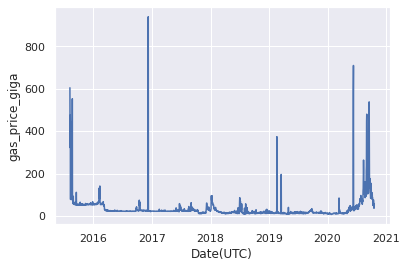

In [ ]:
# plot the time series
sns.lineplot(x=data.index, y=data.gas_price_giga, data=data)

In [ ]:
# naive model for ulti step

# evaluate one or more weekly forcatss against expected values
def evaluate_forcasts(actual:np.ndarray, predicted:np.ndarray):
    scores = []

    for i in range(actual.shape[1]):
        # calculate the mse
        mse = mean_squared_error(actual[:,i], predicted[:,i])
        rmse = np.sqrt(mse)
        scores.append(rmse)

    # calculate overall score
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


In [ ]:
# summarise scores
def summarise_scores(name, score, scores):
    s_scores = ', '.join([f"{s:0.1f}" for s in scores])
    print(f"{name}: {score:0.3f}==> {s_scores}")

In [ ]:
def split_dataset(data:np.ndarray):
    train, test = data[2:1612], data[1612:1899]

    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))

    return train, test

In [ ]:
train, test = split_dataset(data.values)
print(train.shape)
print(test.shape)

(230, 7, 3)
(41, 7, 3)


In [ ]:
train[0, 0, 2]

475.467129048

In [ ]:
# evaluate a single model
def evaluate_model(model_func, train:np.ndarray, test:np.ndarray):
    # history is a list of weekly data
    history = [x for x in train]

    # walk forweward validation over each week
    predictions = []

    for i in range(len(test)):
        # predict the week
        yhat_seq = model_func(history)
        predictions.append(yhat_seq)

        # get real observations and add to history for predicting next week
        history.append(test[i, :])
    predictions = np.array(predictions)

    # evaluate predictions days for each week
    score, scores = evaluate_forcasts(test[:, :, 2], predictions)

    return score, scores


In [ ]:
# daily naive forcast
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]

    # get the gigawei for the last day
    value = last_week[-1, 2]

    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

In [ ]:
# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 2]

In [ ]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
# get the data for the prior week
    last_week = history[-52]
    return last_week[:, 2]

In [ ]:
# define the names and functions for the models we wish to evaluate
models = dict()
models[' daily' ] = daily_persistence
models[' weekly' ] = weekly_persistence
models[' week-oya' ] = week_one_year_ago_persistence

 daily: 77.612==> 30.1, 38.1, 63.6, 109.8, 137.9, 52.8, 43.5
 weekly: 100.379==> 26.5, 35.5, 77.7, 149.6, 186.6, 58.7, 43.5
 week-oya: 100.349==> 53.1, 70.9, 104.8, 128.6, 158.6, 79.1, 60.8


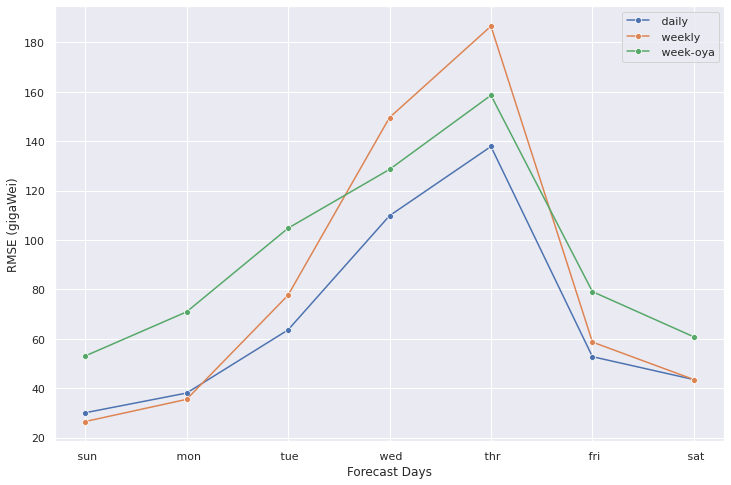

In [ ]:
# evaluate each model
days = [' sun' , ' mon' , ' tue' , ' wed' , ' thr' , ' fri' , ' sat' ]
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_xlabel("Forecast Days")
ax.set_ylabel("RMSE (gigaWei)")
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarise_scores(name , score, scores) # plot scores
    sns.lineplot(x=days, y=scores, label=name, ax=ax, marker="o")
    # plt.plot(days, scores, marker='o' , label=name)
plt.show()    

In [ ]:
####################### CNN HERE

global_result_dict = dict()

In [ ]:
# CNN

# convert history into inputs and outputs
def to_supervised(train:np.ndarray, n_input:int, n_out=7):
    # flatten the data
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, Y = [], []

    in_start = 0

    # step ver history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        if out_end <= len(data):
            x_input = data[in_start:in_end, 2]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            Y.append(data[in_end:out_end, 2])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(Y)

In [ ]:
# train the model
def build_model_cnn(train, n_input, verbose, epochs, bs):
    # prepare the data
    trainx, trainy = to_supervised(train, n_input)

    # define params
    verbose, epochs, bs = verbose, epochs, bs
    n_timesteps, n_features, n_outputs = trainx.shape[1], \
                                         trainx.shape[2], \
                                         trainy.shape[1]

    # define the model
    model = Sequential()

    model.add(Conv1D(16, 3, activation="relu", input_shape=(n_timesteps, n_features)))
    model.add(MaxPool1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))


    model.add(Dense(n_outputs))
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001, ))

    # fit
    H = model.fit(trainx, trainy, epochs=epochs, batch_size=bs, verbose=verbose, callbacks=callbacks)
    return model, H

In [ ]:
# train the model
def build_model_lstm(train, n_input, verbose, epochs, bs):
    # prepare the data
    trainx, trainy = to_supervised(train, n_input)

    # define params
    verbose, epochs, bs = verbose, epochs, bs
    n_timesteps, n_features, n_outputs = trainx.shape[1], \
                                         trainx.shape[2], \
                                         trainy.shape[1]

    # define the model
    model = Sequential()

    model.add(LSTM(8, activation='relu' , input_shape=(n_timesteps, n_features)))
    model.add(Dense(10, activation='relu' ))

    model.add(Dense(n_outputs))
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001,))

    # fit
    H = model.fit(trainx, trainy, epochs=epochs, batch_size=bs, verbose=verbose, callbacks=callbacks)
    return model, H

In [ ]:
def forecast(model, history, n_input):

    data = np.array(history)
    #print("this is data shape")
    #print(data.shape)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last obs
    input_x = data[-n_input:, 2]

    # reshape
    input_x = input_x.reshape((1, len(input_x), 1))

    yhat = model.predict(input_x, verbose=0)

    yhat = yhat[0]
    return yhat

In [ ]:
def evaluate_model(train:np.ndarray, test:np.ndarray, n_input, verbose, epochs, bs, build_model):
    # fit the model
    model, H = build_model(train, n_input, verbose, epochs, bs)

    # history is  alist of weekly data
    history = [x for x in train]

    # walk forward validation over each week
    predictions = []

    for i in range(len(test)):
        # preedict the week
        yhat_sequence = forecast(model, history, n_input)

        # store the predictions
        predictions.append(yhat_sequence)

        # get real observations and add to history
        history.append(test[i, :])

    # evaluate prediction days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forcasts(test[:,:,2], predictions)

    return score, scores, predictions, H

In [ ]:
train, test = split_dataset(data.values)
n_input = 84
verbose=1
epochs = 200
bs = 6

score, scores, preds, H = evaluate_model(train, test, n_input, verbose, epochs, bs, build_model_cnn)
summarise_scores('cnn', score, scores)


Epoch 1/200
254/254 [==============================] - 1s 2ms/step - loss: 853.4410
Epoch 2/200
254/254 [==============================] - 1s 2ms/step - loss: 762.5094
Epoch 3/200
254/254 [==============================] - 1s 2ms/step - loss: 755.9455
Epoch 4/200
254/254 [==============================] - 1s 2ms/step - loss: 750.1368
Epoch 5/200
254/254 [==============================] - 1s 2ms/step - loss: 743.6960
Epoch 6/200
254/254 [==============================] - 1s 2ms/step - loss: 744.3494
Epoch 7/200
254/254 [==============================] - 1s 2ms/step - loss: 745.4839
Epoch 8/200
254/254 [==============================] - 1s 2ms/step - loss: 738.3235
Epoch 9/200
254/254 [==============================] - 1s 2ms/step - loss: 735.3268
Epoch 10/200
254/254 [==============================] - 1s 2ms/step - loss: 733.8785
Epoch 11/200
254/254 [==============================] - 1s 2ms/step - loss: 732.7404
Epoch 12/200
254/254 [==============================] - 1s 2ms/step - loss

KeyboardInterrupt: ignored

In [ ]:
global_result_dict['lstm'] = [list(score), list(scores), list(preds),H]

TypeError: ignored

In [ ]:
import json
with open("/content/drive/My Drive/dump_results.json", mode="w") as file:
  file.write(json.dumps(global_result_dict))

TypeError: ignored

KeyError: ignored

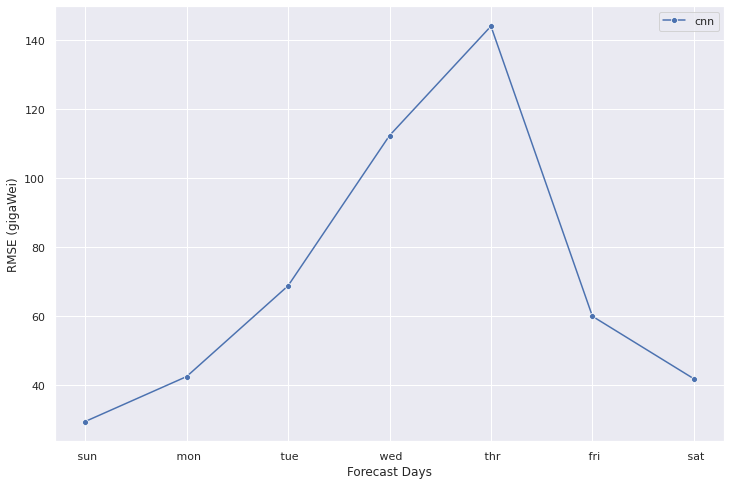

In [ ]:
# plot scores
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_xlabel("Forecast Days")
ax.set_ylabel("RMSE (gigaWei)")
days = [' sun' , ' mon' , ' tue' , ' wed' , ' thr' , ' fri' , ' sat' ]

sns.lineplot(x=days, y=global_result_dict['cnn'][1], label='cnn', ax=ax, marker="o")
sns.lineplot(x=days, y=global_result_dict['lstm'][1], label='lstm', ax=ax, marker="o")
#plt.plot(days, scores, marker='o' , label=' cnn' )
plt.show()

In [ ]:
cnn_preds = global_result_dict['cnn'][2].ravel()
lstm_preds = global_result_dict['lstm'][2].ravel()
test_data = test[:,:,2].ravel()

df = pd.DataFrame(data={'test_data': list(test_data), 'cnn_prediction': list(cnn_preds), 'lstm_prediction': list(lstm_preds)})

In [ ]:
f, ax = plt.subplots(1,1, figsize=(16,8)) #type: Figure, axes.Axes
ax.set_xlabel("Days")
ax.set_ylabel("GasPrice")

sns.lineplot(data=df, label='cnn_prediction', y = 'cnn_prediction',x=list(range(len(df['cnn_prediction']))))
sns.lineplot(data=df, label='lstm_prediction', y = 'lstm_prediction',x=list(range(len(df['lstm_prediction']))))
sns.lineplot(data=df, label='test_data', y = 'test_data',x=list(range(len(df['test_data']))))

plt.show()